In [0]:
#!ps ax | grep python
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import time
import os
import copy
import numpy as np

# Image Classification with Convolutional Neural Networks

**Welcome to the first week of the deep learning study group! We're going to use convolutional neural networks (CNNs) to allow our computer to see - something that is only possible thanks to deep learning.**

### Introduction to our first task: 'Ants vs Bees'

There are 224 labelled Ants and Bees available for training. We are going to build a model to classify these images very accurately using a pre-trained model. This is easy to train on a CPU. After that we are going to train a similar model to classify Dogs vs Cats but this will require a GPU to train reasonably fast.

### Introduction to our second task: 'Dogs vs Cats'
We're going to try to create a model to enter the Dogs vs Cats competition at Kaggle. There are 25,000 labelled dog and cat photos available for training, and 12,500 in the test set that we have to try to label for this competition. According to the Kaggle web-site, when this competition was launched (end of 2013): "State of the art: The current literature suggests machine classifiers can score above 80% accuracy on this task". So if we can beat 80%, then we will be at the cutting edge as of 2013!

# Ants Vs Bees

In [24]:
#@title Import PyTorch modules if they are not present
!pip3 install torch torchvision
!pip3 install tqdm
!git clone https://github.com/kswamy15/dlnerds
#!rm -r dlnerds

You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Cloning into 'dlnerds'...
remote: Counting objects: 79, done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 79 (delta 0), reused 0 (delta 0), pack-reused 75
Unpacking objects: 100% (79/79), done.


In [0]:
## Import the Ants vs Bees data if not already present
if not os.path.isfile('hymenoptera_data.zip'):
  !wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
  !unzip hymenoptera_data.zip  -d data

In [4]:
!ls

data  datalab  dlnerds	hymenoptera_data.zip


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms

In [0]:
from dlnerds.dllib import train as train
from dlnerds.dllib.utils import plot_confusion_matrix as plot_confusion_matrix
from dlnerds.dllib import lr_sched as lr_sched
plt.ion()   # interactive mode

## Transforms
[See all the different pre-defined Transforms of Pytorch here ](http://pytorch.org/docs/master/torchvision/transforms.html)  Data augmentation and normalization for training.  The normalization parameters come from the Imagenet data.  We can try other types of transformations.  The Crop(224) is there to bring all the images to 224 x 224 size.  This is the size of the Imagenet pictures. Just normalization for validation.  The Transformations won't change the original data, just applies the transforms to the dat before it is used in the training loop.

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

## Datasets and DataLoaders
Load the Data into a Pytorch Dataset along with the pre-defined transforms.  The DataLoader is the primary way to build batches of data in Pytorch for training.  The dataloader has to be fed a Dataset object that contains the class name and the image data of each class.  Datasets has a ImageFolder function that can load image data that is stored under folder names of the various classes.  

In [0]:
data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=15,
                                             shuffle=True)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

#check if GPU is available
use_gpu = torch.cuda.is_available()

## See some Sample Images

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

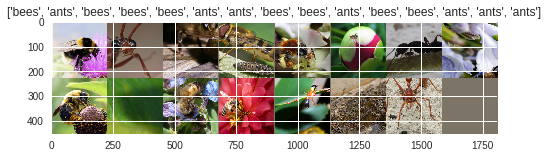

In [10]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Train the model using a pre-trained Resnet model
We are not going to train any of the weights of the pre-trained model except for the last fully connected layer. Imagenet model has 1000 classes.  The Resnet model was trained on the imagenet data.  We are going to replace the last fully connected unit with 2 classes and train that last unit to recognize the ants vs bees.

In [11]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_conv = model_conv.cuda()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /content/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 81142845.64it/s]


## Summary of Resnet Model

In [12]:
model_conv

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b

## Define a Loss function.  
CrossEntropy Loss works very well for training multi class images - with one class per image.  The Loss function also defines the learning parameter and a momentum variable

In [0]:
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized 
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

## Define the Training Model using the Trainer class.  
See details of Trainer class in the github repository

In [0]:
train_conv = train.Trainer(model_conv,image_datasets,dataloaders,criterion,optimizer_conv)

## Find the optimum learning rate to start training
Before we start training the model, we would like to find the optimum learning rate to begin with so that the model can be trained faster.  

The learning rate determines how quickly or how slowly you want to update the weights (or parameters). Learning rate is one of the most difficult parameters to set, because it significantly affect model performance.

The method learn.lr_find() helps you find an optimal learning rate. It uses the technique developed in the 2015 paper Cyclical Learning Rates for Training Neural Networks, where we simply keep increasing the learning rate from a very small value, until the loss stops decreasing. We can plot the learning rate across batches to see what this looks like.

0it [00:00, ?it/s]

Trying learning rates between 1e-05 and 10 over 20 steps (2 epochs)
Epoch 0/1
----------


1it [00:00,  4.43it/s]

Batch No:0 Learn rate 1.00E-05 Batch Loss: 0.8737 


2it [00:00,  4.27it/s]

Batch No:1 Learn rate 2.00E-05 Batch Loss: 0.8491 


3it [00:00,  4.26it/s]

Batch No:2 Learn rate 3.98E-05 Batch Loss: 0.7142 


4it [00:00,  4.25it/s]

Batch No:3 Learn rate 7.94E-05 Batch Loss: 1.0458 


5it [00:01,  4.27it/s]

Batch No:4 Learn rate 1.58E-04 Batch Loss: 0.6438 


6it [00:01,  4.23it/s]

Batch No:5 Learn rate 3.16E-04 Batch Loss: 2.1287 


7it [00:01,  4.21it/s]

Batch No:6 Learn rate 6.31E-04 Batch Loss: 0.5700 


8it [00:01,  4.20it/s]

Batch No:7 Learn rate 1.26E-03 Batch Loss: 0.7018 


9it [00:02,  4.19it/s]

Batch No:8 Learn rate 2.51E-03 Batch Loss: 3.9988 
Batch No:9 Learn rate 5.01E-03 Batch Loss: 26.5515 


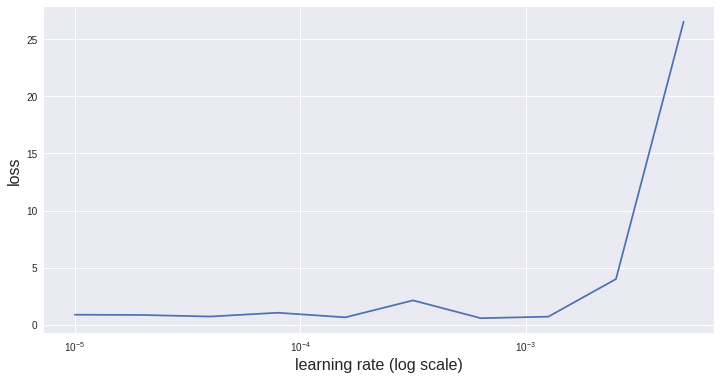

In [20]:
train_conv.lr_find(steps=20)

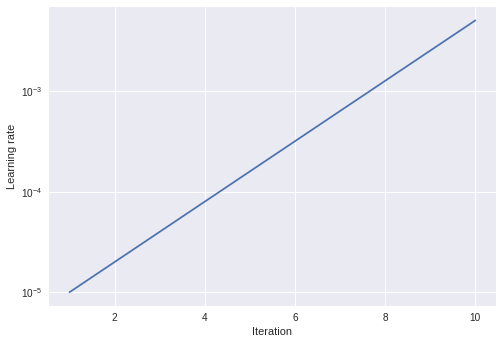

In [21]:
train_conv.plot_lr()

Note that in the previous plot iteration is one iteration (or minibatch) of SGD. In one epoch there are (num_train_samples/num_iterations) of SGD.

## Train the model
Specify the number of epochs to train the model

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 0/4
----------


  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.6673 Acc: 0.6148


  0%|          | 0/17 [00:00<?, ?it/s]

val Loss: 0.3940 Acc: 0.8889

Epoch 1/4
----------


  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.4085 Acc: 0.8238


  0%|          | 0/17 [00:00<?, ?it/s]

val Loss: 0.2513 Acc: 0.9477

Epoch 2/4
----------


  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.2752 Acc: 0.8975


  0%|          | 0/17 [00:00<?, ?it/s]

val Loss: 0.2182 Acc: 0.9542

Epoch 3/4
----------


  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.2723 Acc: 0.8934


  0%|          | 0/17 [00:00<?, ?it/s]

val Loss: 0.1957 Acc: 0.9412

Epoch 4/4
----------


  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.2516 Acc: 0.9057


100%|██████████| 11/11 [00:02<00:00,  3.72it/s]


val Loss: 0.2666 Acc: 0.8954

Training complete in 0m 36s
Best val Acc: 0.954248


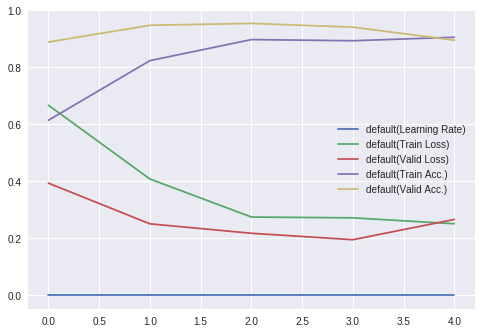

In [26]:
model_conv = train_conv.train_model(num_epochs=5)

## Plot the confusion matrix

100%|██████████| 11/11 [00:02<00:00,  4.58it/s]


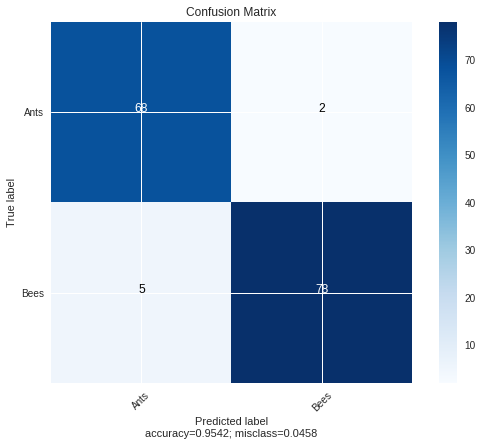

In [27]:
probs,target = train_conv.predict_with_targs()
preds = np.argmax(probs, axis=1)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(target, preds)
plot_confusion_matrix(cm = cm, 
                      normalize    = False,
                      target_names = ['Ants', 'Bees'],
                      title        = "Confusion Matrix")

## Improving our model
Data augmentation
If you try training for more epochs, you'll notice that we start to overfit, which means that our model is learning to recognize the specific images in the training set, rather than generalizing such that we also get good results on the validation set. One way to fix this is to effectively create more data, through data augmentation. This refers to randomly changing the images in ways that shouldn't impact their interpretation, such as horizontal flipping, zooming, and rotating.

Try Different transforms

### stochastic gradient descent with restarts (SGDR)
A variant of learning rate annealing, which gradually decreases the learning rate as training progresses. This is helpful because as we get closer to the optimal weights, we want to take smaller steps.

However, we may find ourselves in a part of the weight space that isn't very resilient - that is, small changes to the weights may result in big changes to the loss. We want to encourage our model to find parts of the weight space that are both accurate and stable. Therefore, from time to time we increase the learning rate (this is the 'restarts' in 'SGDR'), which will force the model to jump to a different part of the weight space if the current area is "spikey". Here's a picture of how that might look if we reset the learning rates 3 times (in this paper they call it a "cyclic LR schedule"):

---



In [0]:
lr_scheduler_conv = lr_sched.myCosineAnnealingLR(optimizer_conv,15,cycle_mult=2)

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 0/4
----------


  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.2379 Acc: 0.9221


  0%|          | 0/17 [00:00<?, ?it/s]

val Loss: 0.1981 Acc: 0.9477

Epoch 1/4
----------


  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.2475 Acc: 0.9262


  0%|          | 0/17 [00:00<?, ?it/s]

val Loss: 0.1880 Acc: 0.9542

Epoch 2/4
----------


  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.2021 Acc: 0.9344


  0%|          | 0/17 [00:00<?, ?it/s]

val Loss: 0.1856 Acc: 0.9608

Epoch 3/4
----------


  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.1829 Acc: 0.9467


  0%|          | 0/17 [00:00<?, ?it/s]

val Loss: 0.1813 Acc: 0.9542

Epoch 4/4
----------


  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.2575 Acc: 0.8852


100%|██████████| 11/11 [00:02<00:00,  3.69it/s]


val Loss: 0.1741 Acc: 0.9608

Training complete in 0m 36s
Best val Acc: 0.960784


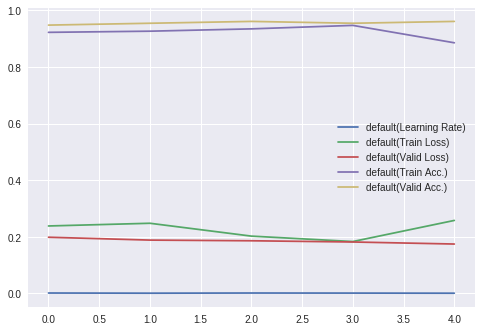

In [29]:
model_conv = train_conv.train_model(scheduler=lr_scheduler_conv,num_epochs=5)

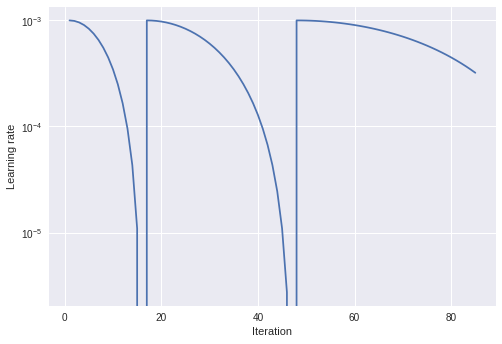

In [30]:
train_conv.plot_lr()

## Fine-tuning and differential learning rate annealing
Now that we have a good final layer trained, we can try fine-tuning the other layers. We are going to unfreeze other layers and train them using different learning rates.  We are going to unfreeze layer4 and layer3 and train them using a lower learning rate than the fully connected layer.  

In [0]:
for param in model_conv.layer4.parameters():
    param.requires_grad = True
for param in model_conv.layer3.parameters():
    param.requires_grad = True  
optimizer_conv = optim.SGD([{'params': model_conv.fc.parameters(), 'lr':1e-3},
                            {'params': model_conv.layer4.parameters(), 'lr':1e-4},
                            {'params': model_conv.layer3.parameters(), 'lr':5e-5}]
                           , lr=1e-4,momentum=0.9)    

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 0/4
----------


  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.2610 Acc: 0.8975


  0%|          | 0/17 [00:00<?, ?it/s]

val Loss: 0.1995 Acc: 0.9477

Epoch 1/4
----------


  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.2381 Acc: 0.9221


100%|██████████| 11/11 [00:02<00:00,  3.78it/s]


val Loss: 0.1748 Acc: 0.9673


  0%|          | 0/17 [00:00<?, ?it/s]


Epoch 2/4
----------


  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.2368 Acc: 0.9057


  0%|          | 0/17 [00:00<?, ?it/s]

val Loss: 0.1786 Acc: 0.9542

Epoch 3/4
----------


  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.2502 Acc: 0.8893


  0%|          | 0/17 [00:00<?, ?it/s]

val Loss: 0.1694 Acc: 0.9542

Epoch 4/4
----------


  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.2063 Acc: 0.9180


100%|██████████| 11/11 [00:02<00:00,  3.82it/s]


val Loss: 0.1705 Acc: 0.9542

Training complete in 0m 40s
Best val Acc: 0.967320


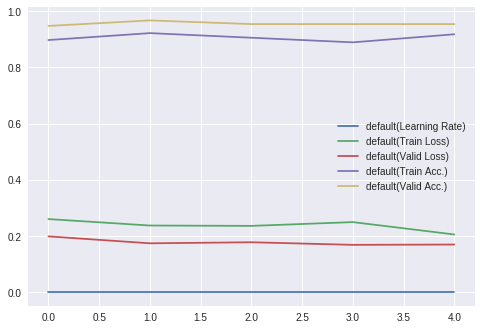

In [32]:
model_conv = train_conv.train_model(optimizer=optimizer_conv,num_epochs=5)

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 0/4
----------


  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.2072 Acc: 0.9057


  0%|          | 0/17 [00:00<?, ?it/s]

val Loss: 0.1780 Acc: 0.9608

Epoch 1/4
----------


  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.1742 Acc: 0.9508


  0%|          | 0/17 [00:00<?, ?it/s]

val Loss: 0.1823 Acc: 0.9542

Epoch 2/4
----------


  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.1769 Acc: 0.9344


  0%|          | 0/17 [00:00<?, ?it/s]

val Loss: 0.1810 Acc: 0.9477

Epoch 3/4
----------


  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.2117 Acc: 0.9057


  0%|          | 0/17 [00:00<?, ?it/s]

val Loss: 0.1792 Acc: 0.9542

Epoch 4/4
----------


  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.1954 Acc: 0.9139


100%|██████████| 11/11 [00:02<00:00,  3.79it/s]


val Loss: 0.1711 Acc: 0.9608

Training complete in 0m 39s
Best val Acc: 0.967320


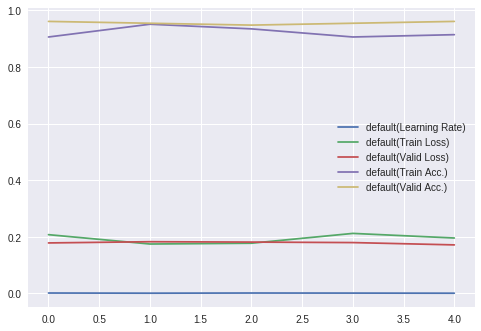

In [35]:
lr_scheduler_conv = lr_sched.myCosineAnnealingLR(optimizer_conv,15,cycle_mult=2)
model_conv = train_conv.train_model(optimizer=optimizer_conv,scheduler=lr_scheduler_conv, num_epochs=5)

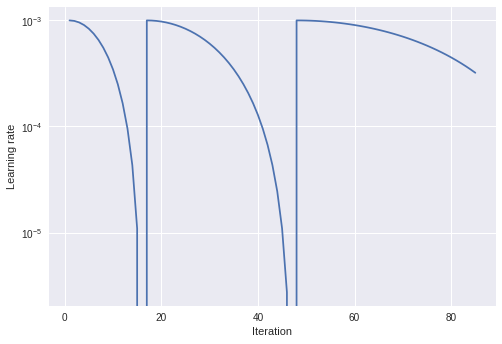

In [36]:
train_conv.plot_lr()

## Review: easy steps to train a world-class image classifier
1.  Enable data augmentation using Pytorch transforms
2.  Use lr_find() to find highest learning rate where loss is still clearly improving
3.  Train last layer from precomputed activations for 1-2 epochs
4.  Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
5.  Unfreeze some layers
6.  Set earlier layers to 3x-10x lower learning rate than next higher layer
7.  Use lr_find() again
8.  Train full network with cycle_mult=2 until over-fitting

## Some helper function:
to check the free GPU memory

In [10]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " I Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Gen RAM Free: 11.3 GB  I Proc size: 1.8 GB
GPU RAM Free: 10806MB | Used: 633MB | Util   6% | Total 11439MB


# Dogs vs Cats

PATH is the path to your data - if you use the recommended setup approaches from the lesson, you won't need to change this. sz is the size that the images will be resized to in order to ensure that the training runs quickly. We'll be talking about this parameter a lot during the course. Leave it at 224 for now.

In [0]:
PATH = "data/dogscats/"
sz=224

It's important that you have a working NVidia GPU set up. The programming framework used to behind the scenes to work with NVidia GPUs is called CUDA. Therefore, you need to ensure the following line returns True before you proceed. If you have problems with this, please check the FAQ and ask for help on the forums.

In [0]:
torch.cuda.is_available()

In addition, NVidia provides special accelerated functions for deep learning in a package called CuDNN. Although not strictly necessary, it will improve training performance significantly, and is included by default in all supported fastai configurations. Therefore, if the following does not return True, you may want to look into why.

In [0]:
torch.backends.cudnn.enabled

## Extra steps if NOT using Crestle or Paperspace or our scripts
The dataset is available at http://files.fast.ai/data/dogscats.zip. You can download it directly on your server by running the following line in your terminal. wget http://files.fast.ai/data/dogscats.zip. You should put the data in a subdirectory of this notebook's directory, called data/. Note that this data is already available in Crestle and the Paperspace fast.ai template.

In [0]:
## Import the Ants vs Bees data if not already present
if not os.path.isfile('dogscats.zip'):
  !wget http://files.fast.ai/data/dogscats.zip
  !unzip hymenoptera_data.zip  -d data

In [0]:
os.listdir(PATH)

In [0]:
os.listdir(f'{PATH}valid')

In [0]:
files = os.listdir(f'{PATH}valid/cats')[:5]
files

In [0]:
img = plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img);

In [0]:
img.shape

## Our first model: quick start
We're going to use a pre-trained model, that is, a model created by some one else to solve a different problem. Instead of building a model from scratch to solve a similar problem, we'll use a model trained on ImageNet (1.2 million images and 1000 classes) as a starting point. The model is a Convolutional Neural Network (CNN), a type of Neural Network that builds state-of-the-art models for computer vision. We'll be learning all about CNNs during this course.

We will be using the resnet34 model. resnet34 is a version of the model that won the 2015 ImageNet competition. Here is more info on resnet models. We'll be studying them in depth later, but for now we'll focus on using them effectively.

How good is this model? Well, as we mentioned, prior to this competition, the state of the art was 80% accuracy. But the competition resulted in a huge jump to 98.9% accuracy, with the author of a popular deep learning library winning the competition. Extraordinarily, less than 4 years later, we can now beat that result in seconds! Even last year in this same course, our initial model had 98.3% accuracy, which is nearly double the error we're getting just a year later, and that took around 10 minutes to compute.

##Choosing a learning rate
The learning rate determines how quickly or how slowly you want to update the weights (or parameters). Learning rate is one of the most difficult parameters to set, because it significantly affect model performance.

The method learn.lr_find() helps you find an optimal learning rate. It uses the technique developed in the 2015 paper Cyclical Learning Rates for Training Neural Networks, where we simply keep increasing the learning rate from a very small value, until the loss stops decreasing. We can plot the learning rate across batches to see what this looks like.

We first create a new learner, since we want to know how to set the learning rate for a new (untrained) model.